In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

%matplotlib inline
sns.set_style('darkgrid')

train_df = pd.read_pickle('./train_cleaned_edit.csv')

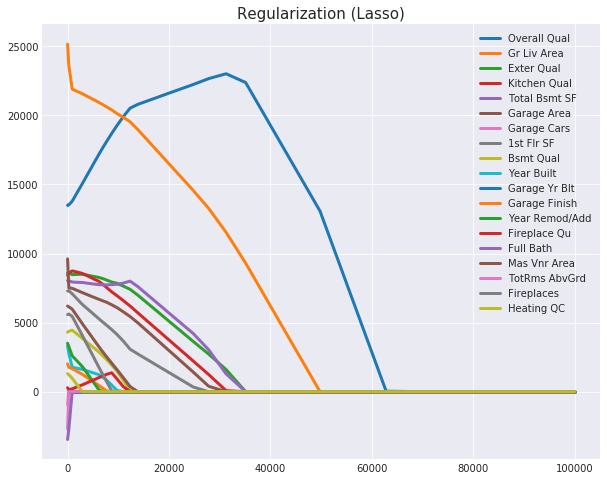

In [2]:
predictors = list(train_df.corr()['SalePrice'].abs().sort_values(ascending = False).keys()[0:20])
predictors.remove('SalePrice')

X = train_df[predictors]
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=8)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)


alpha_list = np.logspace(0, 5, 100)
coefs_list = []
for i in alpha_list:
    model = Lasso(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    
plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list, lw = '3')
plt.title("Regularization (Lasso)", fontsize = 15)
plt.legend(predictors);

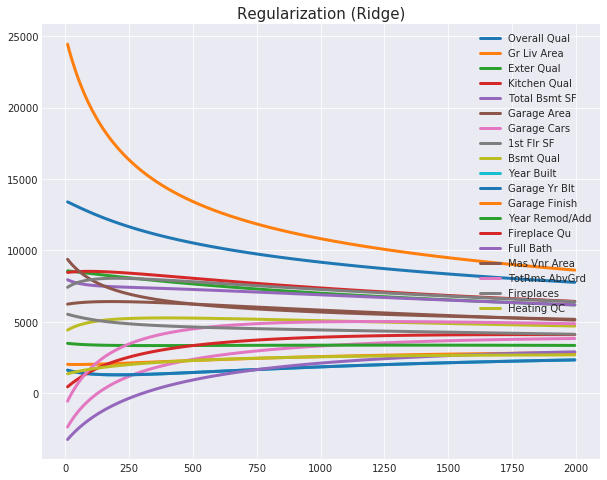

In [3]:
alpha_list = np.logspace(1, 3.3, 100)
coefs_list = []
for i in alpha_list:
    model = Ridge(alpha = i)
    model.fit(X_scaled, y_train)
    coefs_list.append(model.coef_)
    
plt.figure(figsize = (10,8))
plt.plot(alpha_list, coefs_list, lw = '3')
plt.title("Regularization (Ridge)", fontsize = 15)
plt.legend(predictors);

In [4]:
model = LassoCV(alphas=np.linspace(0.001, 100, 1000), cv = 10, max_iter = 100000)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.8553378949860574, 0.8647966000502834, 87.08721621621622)

In [5]:
model = RidgeCV(alphas=np.linspace(0.001, 100, 100), cv = 10)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test), model.alpha_

(0.8552496195929624, 0.8651174592878299, 25.25327272727273)

In [6]:
ratios = [.01, .1, .5, .7, .9, .95, .99, 1]
model = ElasticNetCV(l1_ratio = ratios, alphas=np.linspace(0.001, 10, 1000), max_iter = 10000, cv = 5)
model.fit(X_scaled, y_train)

model.score(X_scaled, y_train),model.score(X_test_scaled, y_test),model.alpha_, model.l1_ratio_

(0.8551912956964555, 0.8650815500585514, 2.012810810810811, 0.99)

- From this preliminary screening of the different regularization methods, let's choose to use Ridge.  Lasso is driving the top 15 features to 0, but I think it might be worth keeping the regularize "less important" features for the final model (Also because ElasticNetCV is telling us  it's best l1_ratio = 0.99, which is using primarily Ridge regularization anyway).

In [7]:
master_train_df = pd.read_pickle('./master_train.pkl')

new_outlier_train = master_train_df.loc[~(
    (master_train_df['Gr Liv Area'] > 5000) |
    (master_train_df['Garage Area'] > 1200) |
    (master_train_df['Total Bsmt SF'] > 3000) |
    (master_train_df['1st Flr SF'] > 3000)),:
]
print(master_train_df.shape)
print(new_outlier_train.shape)

(2051, 256)
(2040, 256)


In [8]:
predictors = [col for col in list(new_outlier_train.columns) if col != "SalePrice"]

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

ss = StandardScaler()
ss.fit(X_train)
X_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

model = RidgeCV(alphas=np.linspace(1,500,100), cv = 5)
model.fit(X_scaled, y_train)

print("Model Scores-> Train: ", model.score(X_scaled, y_train).round(3),\
                      "Test: ", model.score(X_test_scaled, y_test).round(3), "Alpha = ", model.alpha_.round(2))

Model Scores-> Train:  0.926 Test:  0.925 Alpha =  157.25


In [9]:
Xs = ss.transform(X)
print("CV Score:", cross_val_score(model, Xs, y, cv =5).mean().round(3))

CV Score: 0.908


In [10]:
def PlotResiduals(y_train_predict,y_train):
    plt.figure(figsize = (10,8))
    plt.scatter(y_train_predict, y_train - y_train_predict,
                c='steelblue', marker = 'o', s = 60.0, edgecolor = 'white', label = 'Training data', alpha =0.5)
    plt.scatter(y_test_predict, y_test - y_test_predict,
               c='limegreen', marker = 's', s = 60.0, edgecolor = 'white', label = 'Test Data', alpha = 0.5)
    plt.xlabel('True Values', fontsize = 15)
    plt.ylabel('Residuals', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.hlines(y=0, xmin = -100000, xmax =600000, color = 'black', lw=2)
    plt.show()

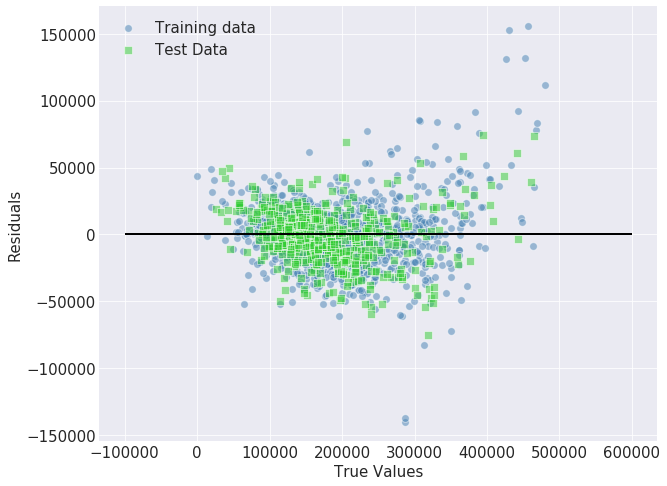

In [11]:
y_train_predict = model.predict(X_scaled)
y_test_predict = model.predict(X_test_scaled)

PlotResiduals(y_train_predict,y_train)

- Not bad, but it looks like there's a bit of a non-linear trend to the residuals.  Let's apply a Polynomial fit and make a pipeline to perform these transformations.

In [12]:
test_coefs = pd.DataFrame({
    "feature":list(X.columns),
    "coefs":abs(model.coef_)}).sort_values(by = 'coefs',ascending=False)

test_coefs.head(80)

,coefs,feature
28,11125.296470,Gr Liv Area
7,9634.308140,Overall Qual
25,7794.844601,1st Flr SF
22,6907.444296,Total Bsmt SF
18,6423.245060,BsmtFin SF 1
158,6139.810761,Neighborhood_NridgHt
11,6093.419925,Mas Vnr Area
26,5826.364007,2nd Flr SF
164,4920.215299,Neighborhood_StoneBr
35,4889.458615,Kitchen Qual


In [13]:
predictors = test_coefs.loc[test_coefs['coefs'] > 1000, :]['feature'].tolist()

X = new_outlier_train[predictors]
y = new_outlier_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

ss = StandardScaler()
poly = PolynomialFeatures(degree = 2)
ridge = Ridge(alpha = 206, max_iter = 10000, tol = 0.001)

pipe = Pipeline([ 
    ('poly', poly),
    ('ss', ss),                                
    ('ridge', ridge)                               
    
])

params = {

    
}

gs = GridSearchCV(pipe, param_grid = params, cv =3, n_jobs = 2)
gs.fit(X_train, y_train)


print(gs.best_score_)
print(gs.best_params_)
gs.score(X_train, y_train), gs.score(X_test, y_test)

0.921881641698158
{}


(0.9762068446873711, 0.9228960619660539)

- Also not bad!  Looks like we're overfitting a bit on the training set, but the cross-validated GS score seems inline with what we're getting on our test split.  Considering the residual plot below, we were definitely able to cut down the non-linear trend we saw earlier by employing a polynomial fit.  This is confirmed by the residuals of both the test and training data, which are more randomly dispersed.

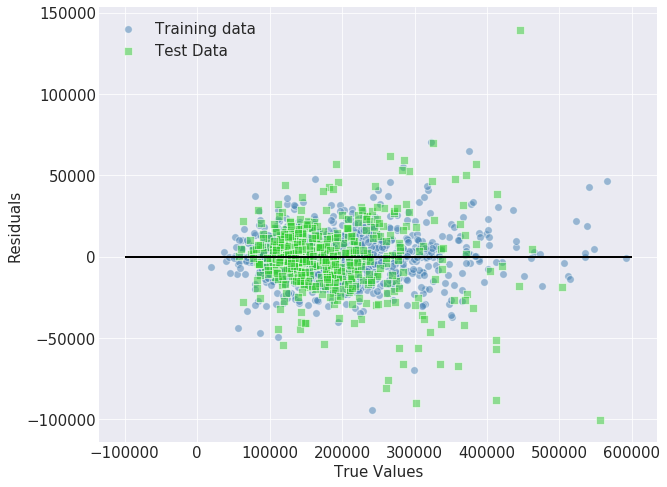

In [15]:
y_train_predict = gs.predict(X_train)
y_test_predict = gs.predict(X_test)

PlotResiduals(y_train_predict,y_train)

In [16]:
from sklearn.externals import joblib

In [17]:
joblib.dump(gs, '/assets/Ridge_Poly_Tuned.pkl')

['Ridge_Poly_Tuned.pkl']

In [19]:
ridge_pickle = joblib.load('Ridge_Poly_Tuned.pkl')